In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import itertools
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
#set output directory
outdir = "output_noGuo"
os.makedirs(os.path.join(outdir,"promoters"), exist_ok=True)
sample_data = pd.read_csv("data/EMseq_samples_noGuo.csv")
sample_data

,id,base_name,Cell_type,TFs,Cell_line,Sex,sample_key,Study,Cells
0,01_,01_A4_1_val_1_bismark_bt2_pe.deduplicated.bismark,hPGCLC,NaN,A4,M,hPGCLC,Smela2024,hPGCLC
1,02_,02_D3_1_val_1_bismark_bt2_pe.deduplicated.bismark,oogonia_old,D3,F3,F,oogonia_old,Smela2024,iOLC -DNMTi
2,03_,03_DNR3_1_val_1_bismark_bt2_pe.deduplicated.bi...,oogonia_old,D3,F3,F,oogonia_old,Smela2024,iOLC -DNMTi
3,04_,04_F2_1_val_1_bismark_bt2_pe.deduplicated.bismark,hPGCLC,NaN,F2,F,hPGCLC,Smela2024,hPGCLC
4,05_,05_F3_1_val_1_bismark_bt2_pe.deduplicated.bismark,hiPSC_primed,NaN,F3,F,hiPSC_primed,Smela2024,hiPSC primed
...,...,...,...,...,...,...,...,...,...
59,60_,DRR142997_trimmed_bismark_bt2.deduplicated.bis...,aggregate cultured PGCLC,NaN,ag120_1390G3_VT,F,xrOvary_day120_DDX4+,Yamashiro2018,xrOvary day120
60,61_,DRR142998_trimmed_bismark_bt2.deduplicated.bis...,aggregate cultured PGCLC,NaN,ag120_1390G3_VT,F,xrOvary_day120_DDX4+,Yamashiro2018,xrOvary day120
61,62_,DRR142999_trimmed_bismark_bt2.deduplicated.bis...,aggregate cultured PGCLC,NaN,ag120_1390G3_VT,F,xrOvary_day120_DDX4+,Yamashiro2018,xrOvary day120
62,63_,DRR143000_trimmed_bismark_bt2.deduplicated.bis...,aggregate cultured PGCLC,NaN,ag120_1390G3_VT,F,xrOvary_day120_DDX4+,Yamashiro2018,xrOvary day120


In [12]:
def aggregate_beds(sample_directory, sample_list_df, sample_suffix, base_bed, bed_col_names=["chr","start","end"]):
    base_df = pd.read_csv(base_bed, sep='\t', names = bed_col_names, usecols = range(0,len(bed_col_names)))
    sample_list = [base_df] #Make a list, start with just the bed file. 
    
    for index, filename in enumerate(sample_list_df["base_name"]):
        full_name = sample_directory + filename + sample_suffix
        print("Reading: "+full_name)
        #Read the file and take the last two columns
        try:
            data = pd.read_csv(full_name, usecols = ["N_methy_ori","N_total_ori"], sep = '\t')
            #Make the column names unique
            #don't do this: #col_key = filename.split("_")[0]
            col_key = sample_list_df["id"].iloc[index]
            
            data.rename(columns = {"N_methy_ori":col_key+"methyl_counts","N_total_ori":col_key+"total_counts"}, inplace = True)
            data[col_key+"methyl_pct"]=data[col_key+"methyl_counts"]/data[col_key+"total_counts"]*100
            #append to the sample list
            sample_list.append(data)
        except Exception as e:
            print(e)
            
    samples = pd.concat(sample_list, axis = 1)
    return samples

def aggregate_samples(data_df, sample_metadata, cell_type_list = None):
    methyl_pct_list = []
    if cell_type_list is None:
        cell_type_list = list(sample_metadata["sample_key"].unique())
    for type in cell_type_list:
        sample_groups = sample_metadata[sample_metadata["sample_key"]==type]["id"]
        methyl_counts_cols = [x + "methyl_counts" for x in sample_groups] #get all columns with methyl counts
        total_counts_cols = [x + "total_counts" for x in sample_groups] #get all columns with total counts
        methyl_pct = data_df[methyl_counts_cols].sum(axis=1) / data_df[total_counts_cols].sum(axis=1) * 100
        methyl_pct_list.append(methyl_pct)
        
    methyl_pct_aggregated = pd.concat([data_df[["chr","start","end","gene"]]] + methyl_pct_list, axis = 1)
    methyl_pct_aggregated.columns = ["chr","start","end","gene"] + cell_type_list
    methyl_pct_aggregated.dropna(inplace=True)
    return methyl_pct_aggregated

def methyl_percent_plot(key_x, key_y, xlabel, ylabel, title, methyl_pct_aggregated):

    values = np.vstack([methyl_pct_aggregated[key_x], methyl_pct_aggregated[key_y]])
    kernel = stats.gaussian_kde(values)(values)
    
    sns.scatterplot(x=methyl_pct_aggregated[key_x],y=methyl_pct_aggregated[key_y], c = kernel, cmap = 'viridis', alpha = 0.8,s = 5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.title(title)
    plt.savefig(str(title + "_" + ylabel + " vs " + xlabel + ".png").replace(" ", "_"), dpi = 256)

def methyl_percent_jointplot(key_x, key_y, xlabel, ylabel, title, methyl_pct_aggregated, filename, size=5):
    g = sns.jointplot(data=methyl_pct_aggregated, x=key_x, y=key_y, joint_kws={'color':'#00AFD7'}, marginal_kws={'color':'#00AFD7', 'fill':True}, kind = "kde")
    g.plot_joint(sns.scatterplot, zorder=0, s=3, color='black', alpha=0.6)#size= 3, alpha=0.8, color = "black")

    f=plt.gcf()
    f.set_figheight(size)
    f.set_figwidth(size)
    
    plt.xlabel(xlabel, fontsize = 14)
    plt.ylabel(ylabel, fontsize = 14)
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.suptitle(title, fontsize = 14)
    plt.savefig(filename, dpi = 256, bbox_inches="tight")

def pairwise_plot(methyl_df,cell_type_list,out_dir="output", title="Percent Methylation"):
    for type1,type2 in itertools.combinations(cell_type_list,2):
        print(f"plotting: {type1} vs {type2}")
        methyl_percent_jointplot(type1, type2, "% in "+type1, "% in "+type2, title,
                             promoters_aggregated, os.path.join(out_dir, type1+"_vs_"+type2+".png"))
        plt.close()

def pca_plot(methyl_df, sample_data, title, outdir = outdir, hue_key="sample_key", style_key=None, hue_order=None):
    #get columns with percentage data
    methyl_pct = methyl_df.loc[:,methyl_df.columns.str.contains("_pct")].dropna()
    #fit PCA
    pca = PCA(n_components=2)
    pca.fit(methyl_pct)
    #plot PCA
    if style_key is not None:
        g = sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue = sample_data[hue_key], style = sample_data[style_key], hue_order=hue_order)
    else:
        g = sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue = sample_data[hue_key])
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    f=plt.gcf()
    f.set_figheight(5)
    f.set_figwidth(5)

    
    plt.xlabel(f"PC1: {(pca.explained_variance_ratio_[0]*100):.1f}% variance")
    plt.ylabel(f"PC2: {(pca.explained_variance_ratio_[1]*100):.1f}% variance")
    plt.title(title)
    plt.savefig(os.path.join(outdir, title+".png"), bbox_inches="tight", dpi=256)
    plt.savefig(os.path.join(outdir, title+".svg"), bbox_inches="tight")


def pca_plot_scale(methyl_df, sample_data, title, outdir = outdir, hue_key="sample_key", style_key=None, hue_order=None):
    #get columns with percentage data
    methyl_pct = methyl_df.loc[:,methyl_df.columns.str.contains("_pct")].dropna()

    #Scale data to have zero mean and unit variance
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(methyl_pct)
    
    #fit PCA
    pca = PCA(n_components=2)
    pca.fit(normalized_data)
    #plot PCA
    if style_key is not None:
        g = sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue = sample_data[hue_key], style = sample_data[style_key], hue_order=hue_order)
    else:
        g = sns.scatterplot(x=pca.components_[0],y=pca.components_[1], hue = sample_data[hue_key])
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    f=plt.gcf()
    f.set_figheight(5)
    f.set_figwidth(5)

    
    plt.xlabel(f"PC1: {(pca.explained_variance_ratio_[0]*100):.1f}% variance")
    plt.ylabel(f"PC2: {(pca.explained_variance_ratio_[1]*100):.1f}% variance")
    plt.title(title)
    plt.savefig(os.path.join(outdir, title+"_scaledPCA.png"), bbox_inches="tight", dpi=256)
    plt.savefig(os.path.join(outdir, title+"_scaledPCA.svg"), bbox_inches="tight")
    

In [4]:
proms_df = aggregate_beds(base_bed="base_beds/Hs_EPDnew_006_hg38_900up400down.bed", bed_col_names = ["chr","start","end","gene"], sample_directory="data/promoters_900up400down/", sample_list_df = sample_data, sample_suffix=".prom900up400down_aggregated.bed")
proms_df

Reading: data/promoters_900up400down/01_A4_1_val_1_bismark_bt2_pe.deduplicated.bismark.prom900up400down_aggregated.bed
Reading: data/promoters_900up400down/02_D3_1_val_1_bismark_bt2_pe.deduplicated.bismark.prom900up400down_aggregated.bed
Reading: data/promoters_900up400down/03_DNR3_1_val_1_bismark_bt2_pe.deduplicated.bismark.prom900up400down_aggregated.bed
Reading: data/promoters_900up400down/04_F2_1_val_1_bismark_bt2_pe.deduplicated.bismark.prom900up400down_aggregated.bed
Reading: data/promoters_900up400down/05_F3_1_val_1_bismark_bt2_pe.deduplicated.bismark.prom900up400down_aggregated.bed
Reading: data/promoters_900up400down/06_PGP1_1_val_1_bismark_bt2_pe.deduplicated.bismark.prom900up400down_aggregated.bed
Reading: data/promoters_900up400down/07_F2_D4TDZG_1_val_1_bismark_bt2_pe.deduplicated.bismark.prom900up400down_aggregated.bed
Reading: data/promoters_900up400down/08_F3_D4TGS3_1_val_1_bismark_bt2_pe.deduplicated.bismark.prom900up400down_aggregated.bed
Reading: data/promoters_900up4

,chr,start,end,gene,01_methyl_counts,01_total_counts,01_methyl_pct,02_methyl_counts,02_total_counts,02_methyl_pct,...,61_methyl_pct,62_methyl_counts,62_total_counts,62_methyl_pct,63_methyl_counts,63_total_counts,63_methyl_pct,64_methyl_counts,64_total_counts,64_methyl_pct
0,chr1,958845,960145,NOC2L_1,35.0,1066.0,3.283302,13.0,196.0,6.632653,...,2.866242,1.0,214.0,0.467290,2.0,226.0,0.884956,3.0,254.0,1.181102
1,chr1,959732,961032,KLHL17_1,31.0,688.0,4.505814,17.0,186.0,9.139785,...,4.500000,1.0,151.0,0.662252,3.0,170.0,1.764706,5.0,233.0,2.145923
2,chr1,965581,966881,PLEKHN1_1,170.0,637.0,26.687598,73.0,108.0,67.592593,...,0.628931,6.0,190.0,3.157895,0.0,140.0,0.000000,8.0,139.0,5.755396
3,chr1,976270,977570,PERM1_1,6.0,223.0,2.690583,19.0,51.0,37.254902,...,10.227273,0.0,43.0,0.000000,1.0,50.0,2.000000,1.0,61.0,1.639344
4,chr1,999686,1000986,HES4_1,15.0,916.0,1.637555,2.0,356.0,0.561798,...,0.564972,1.0,210.0,0.476190,1.0,274.0,0.364964,1.0,228.0,0.438596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29593,chrX,155612541,155613841,TMLHE_1,33.0,163.0,20.245399,27.0,96.0,28.125000,...,35.159817,38.0,151.0,25.165563,32.0,134.0,23.880597,43.0,179.0,24.022346
29594,chrX,155766851,155768151,SPRY3_2,50.0,139.0,35.971223,1.0,17.0,5.882353,...,4.255319,1.0,61.0,1.639344,1.0,63.0,1.587302,2.0,49.0,4.081633
29595,chrX,155880444,155881744,VAMP7_1,99.0,357.0,27.731092,19.0,84.0,22.619048,...,36.458333,74.0,228.0,32.456140,86.0,229.0,37.554585,84.0,216.0,38.888889
29596,chrY,18992408,18993708,CD24_1,15.0,198.0,7.575758,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
promoters_aggregated = aggregate_samples(proms_df, sample_data)
promoters_aggregated.to_csv(os.path.join(outdir,"promoters/2024-01-17_promoters_aggregated_combined_samples.csv"))
promoters_aggregated

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_F,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+
0,chr1,958845,960145,NOC2L_1,3.551913,9.239766,17.928903,4.091456,5.591398,3.054449,...,0.966495,0.964852,32.403467,36.092810,34.097989,2.052239,1.680000,9.104478,5.062837,1.083685
1,chr1,959732,961032,KLHL17_1,4.562178,8.633094,20.948617,4.675325,10.979730,3.426124,...,1.824818,0.803213,28.048994,32.406250,27.025480,1.714986,1.762115,6.679764,3.466572,1.822323
2,chr1,965581,966881,PLEKHN1_1,22.511211,36.489607,32.699168,16.504854,21.823204,6.013746,...,0.877193,1.285583,39.486046,29.887860,27.450070,5.515152,1.076555,10.205696,4.831461,2.200000
3,chr1,976270,977570,PERM1_1,2.150538,37.295082,48.128342,17.721519,9.961686,3.437500,...,6.086957,6.201550,43.834688,43.422584,35.748792,7.643312,4.361371,21.780303,11.887073,3.539823
4,chr1,999686,1000986,HES4_1,1.141141,1.260504,2.857143,2.320888,6.872852,0.945946,...,1.170213,0.469484,2.502737,1.883476,1.332998,0.742240,0.763942,0.566343,0.725639,0.424929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29589,chrX,155334148,155335448,CLIC2_1,37.500000,77.611940,86.458333,23.076923,12.820513,6.410256,...,4.597701,6.451613,81.720430,89.285714,73.275862,5.882353,5.000000,19.354839,3.030303,1.980198
29592,chrX,155611685,155612985,SPRY3_1,31.084337,37.012987,26.000000,7.374631,14.963504,2.135231,...,2.109705,0.664452,34.583333,6.036217,3.352770,25.706472,25.963149,0.000000,0.682594,25.688976
29593,chrX,155612541,155613841,TMLHE_1,40.229885,48.497854,35.359116,7.177033,12.389381,1.766784,...,3.002309,1.351351,42.828146,17.187500,9.770115,27.772768,27.107438,4.318182,3.171642,29.943503
29594,chrX,155766851,155768151,SPRY3_2,32.046332,32.374101,47.368421,6.179775,6.372549,1.293103,...,4.733728,1.290323,39.473684,52.000000,36.521739,4.225352,4.166667,24.206349,4.249292,2.279202


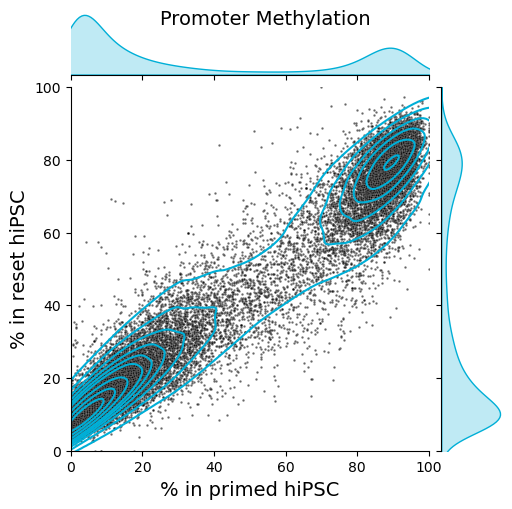

In [6]:
methyl_percent_jointplot("hiPSC_primed", "hiPSC_naive", "% in primed hiPSC", "% in reset hiPSC", "Promoter Methylation",
                         promoters_aggregated, os.path.join(outdir,"promoters/hiPSC_primed_vs_reset.png"))

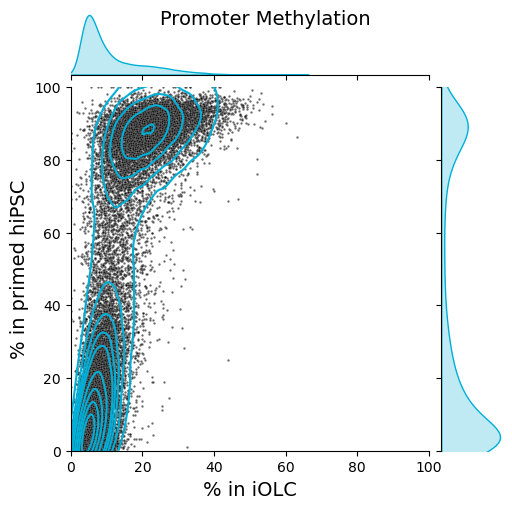

In [7]:
methyl_percent_jointplot("oogonia_new_D5", "hiPSC_primed", "% in iOLC", "% in primed hiPSC", "Promoter Methylation",
                         promoters_aggregated, os.path.join(outdir,"promoters/iOLC_vs_hiPSC_primed.png"))

In [8]:
promoters_aggregated

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_F,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+
0,chr1,958845,960145,NOC2L_1,3.551913,9.239766,17.928903,4.091456,5.591398,3.054449,...,0.966495,0.964852,32.403467,36.092810,34.097989,2.052239,1.680000,9.104478,5.062837,1.083685
1,chr1,959732,961032,KLHL17_1,4.562178,8.633094,20.948617,4.675325,10.979730,3.426124,...,1.824818,0.803213,28.048994,32.406250,27.025480,1.714986,1.762115,6.679764,3.466572,1.822323
2,chr1,965581,966881,PLEKHN1_1,22.511211,36.489607,32.699168,16.504854,21.823204,6.013746,...,0.877193,1.285583,39.486046,29.887860,27.450070,5.515152,1.076555,10.205696,4.831461,2.200000
3,chr1,976270,977570,PERM1_1,2.150538,37.295082,48.128342,17.721519,9.961686,3.437500,...,6.086957,6.201550,43.834688,43.422584,35.748792,7.643312,4.361371,21.780303,11.887073,3.539823
4,chr1,999686,1000986,HES4_1,1.141141,1.260504,2.857143,2.320888,6.872852,0.945946,...,1.170213,0.469484,2.502737,1.883476,1.332998,0.742240,0.763942,0.566343,0.725639,0.424929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29589,chrX,155334148,155335448,CLIC2_1,37.500000,77.611940,86.458333,23.076923,12.820513,6.410256,...,4.597701,6.451613,81.720430,89.285714,73.275862,5.882353,5.000000,19.354839,3.030303,1.980198
29592,chrX,155611685,155612985,SPRY3_1,31.084337,37.012987,26.000000,7.374631,14.963504,2.135231,...,2.109705,0.664452,34.583333,6.036217,3.352770,25.706472,25.963149,0.000000,0.682594,25.688976
29593,chrX,155612541,155613841,TMLHE_1,40.229885,48.497854,35.359116,7.177033,12.389381,1.766784,...,3.002309,1.351351,42.828146,17.187500,9.770115,27.772768,27.107438,4.318182,3.171642,29.943503
29594,chrX,155766851,155768151,SPRY3_2,32.046332,32.374101,47.368421,6.179775,6.372549,1.293103,...,4.733728,1.290323,39.473684,52.000000,36.521739,4.225352,4.166667,24.206349,4.249292,2.279202


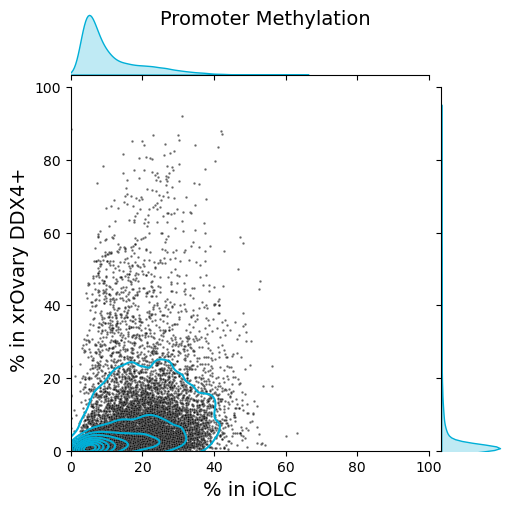

In [9]:
methyl_percent_jointplot("oogonia_new_D5", "xrOvary_day120_DDX4+", "% in iOLC", "% in xrOvary DDX4+", "Promoter Methylation",
                         promoters_aggregated, os.path.join(outdir,"promoters/iOLC_vs_xrOvary.png"))

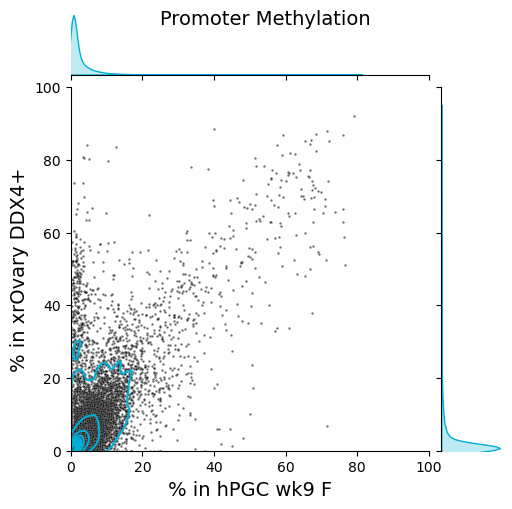

In [10]:
methyl_percent_jointplot("hPGC_wk9_F", "xrOvary_day120_DDX4+", "% in hPGC wk9 F", "% in xrOvary DDX4+", "Promoter Methylation",
                         promoters_aggregated, os.path.join(outdir,"promoters/hPGC_vs_xrOvary.png"))

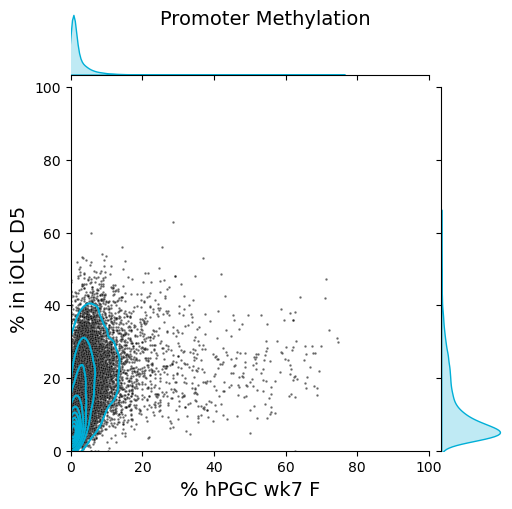

In [11]:
methyl_percent_jointplot("hPGC_wk7_F", "oogonia_new_D5", "% hPGC wk7 F", "% in iOLC D5", "Promoter Methylation",
                         promoters_aggregated, os.path.join(outdir,"promoters/hPGC_wk7F_vs_iOLC_D5.png"))

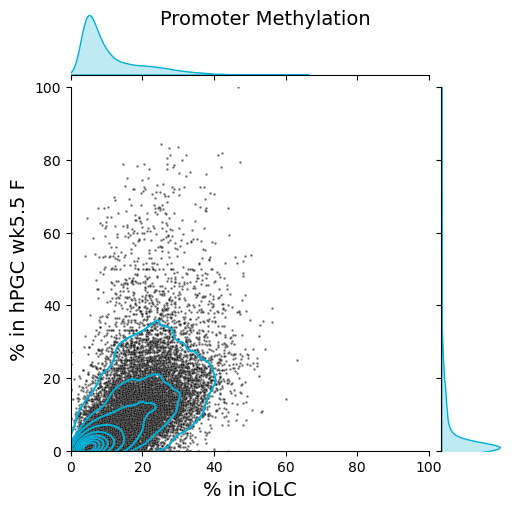

In [12]:
methyl_percent_jointplot("oogonia_new_D5", "hPGC_wk5.5_F", "% in iOLC", "% in hPGC wk5.5 F", "Promoter Methylation",
                         promoters_aggregated, os.path.join(outdir,"promoters/hPGC_wk5.5F_vs_iOLC_D5_2.png"))

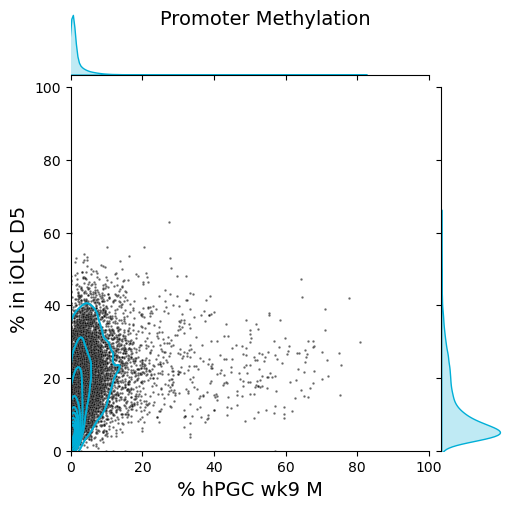

In [13]:
methyl_percent_jointplot("hPGC_wk9_M", "oogonia_new_D5", "% hPGC wk9 M", "% in iOLC D5", "Promoter Methylation",
                         promoters_aggregated, os.path.join(outdir,"promoters/hPGC_wk9M_vs_iOLC_D5.png"))

# Load CpG Islands

In [4]:
islands_df = aggregate_beds(base_bed="base_beds/2023-12-29_CpGislands_export.bed", bed_col_names = ["chr","start","end","gene"], sample_directory="data/CpG_islands/", sample_list_df = sample_data, sample_suffix=".CpG_islands_aggregated.bed")
#islands_df.to_csv(os.path.join(outdir,"CpG_islands/2024-01-17_CpG_islands_aggregated.csv")
CpG_filtered = islands_df.dropna()
CpG_aggregated = aggregate_samples(CpG_filtered, sample_data)
CpG_aggregated.to_csv(os.path.join(outdir,"2024-01-17_CpG_islands_aggregated_combined_samples.csv"))
CpG_aggregated

Reading: data/CpG_islands/01_A4_1_val_1_bismark_bt2_pe.deduplicated.bismark.CpG_islands_aggregated.bed
Reading: data/CpG_islands/02_D3_1_val_1_bismark_bt2_pe.deduplicated.bismark.CpG_islands_aggregated.bed
Reading: data/CpG_islands/03_DNR3_1_val_1_bismark_bt2_pe.deduplicated.bismark.CpG_islands_aggregated.bed
Reading: data/CpG_islands/04_F2_1_val_1_bismark_bt2_pe.deduplicated.bismark.CpG_islands_aggregated.bed
Reading: data/CpG_islands/05_F3_1_val_1_bismark_bt2_pe.deduplicated.bismark.CpG_islands_aggregated.bed
Reading: data/CpG_islands/06_PGP1_1_val_1_bismark_bt2_pe.deduplicated.bismark.CpG_islands_aggregated.bed
Reading: data/CpG_islands/07_F2_D4TDZG_1_val_1_bismark_bt2_pe.deduplicated.bismark.CpG_islands_aggregated.bed
Reading: data/CpG_islands/08_F3_D4TGS3_1_val_1_bismark_bt2_pe.deduplicated.bismark.CpG_islands_aggregated.bed
Reading: data/CpG_islands/09_PGP1_D4TR8G_1_val_1_bismark_bt2_pe.deduplicated.bismark.CpG_islands_aggregated.bed
Reading: data/CpG_islands/10_F2_D4TDZG_1_val_1

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_F,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+
1,chr1,135124,135563,CpG: 30,86.111111,98.514851,93.464052,40.277778,29.054054,33.777778,...,10.447761,2.061856,97.586727,94.915254,93.500000,22.590361,5.603448,62.162162,35.598706,4.583333
8,chr1,778604,779167,CpG: 60,0.694444,1.470588,2.702703,2.005013,5.642633,3.225806,...,0.000000,0.274348,0.627716,0.283554,0.678222,0.500000,0.432900,0.381679,0.351803,0.414079
13,chr1,904314,905239,CpG: 119,0.578035,11.196319,10.806452,7.084785,8.288770,2.663438,...,1.629328,0.914286,3.112481,1.371951,0.571102,1.548205,0.767263,0.907258,0.834939,1.991614
14,chr1,908919,910503,CpG: 154,18.604651,96.258503,93.818681,26.092715,15.337423,21.582734,...,5.333333,0.877193,87.544680,92.581047,77.516463,2.845797,0.645995,22.859831,7.579102,1.841197
15,chr1,919385,919593,CpG: 16,53.688525,93.203883,89.265537,19.130435,13.698630,23.684211,...,4.306220,2.232143,92.736842,90.039841,76.153846,9.347826,0.000000,19.014085,8.860759,6.882591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31657,chrX,155070787,155071520,CpG: 73,31.333333,42.222222,19.626168,7.142857,18.095238,2.523659,...,0.639386,0.700935,25.011410,0.895857,0.698603,35.687500,28.807107,0.431034,0.961538,39.058172
31659,chrX,155264018,155264622,CpG: 52,51.115619,46.731235,21.134021,7.602339,10.820896,1.861702,...,0.157233,0.000000,29.212254,0.789889,0.717360,32.502308,33.333333,0.759013,1.013942,34.842951
31664,chrX,155612451,155613058,CpG: 44,33.704735,37.528604,18.374558,6.211180,14.423077,0.440529,...,2.505695,0.680272,33.383010,0.674157,0.301205,29.277567,28.146853,0.000000,0.782779,32.275132
31899,chrY,11306915,11308238,CpG: 92,79.232506,57.692308,77.941176,24.864865,11.475410,15.441176,...,40.842491,43.421053,78.093932,82.933579,81.488854,56.208609,54.901961,73.755924,70.570175,56.033578


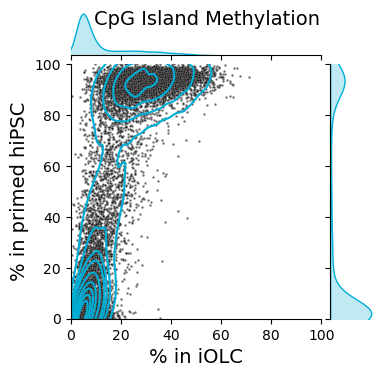

In [16]:
methyl_percent_jointplot("oogonia_new_D5", "hiPSC_primed", "% in iOLC", "% in primed hiPSC", "CpG Island Methylation",
                         CpG_aggregated, os.path.join(outdir,"CpG_islands/iOLC_vs_hiPSC_primed.png"),size=3.5)

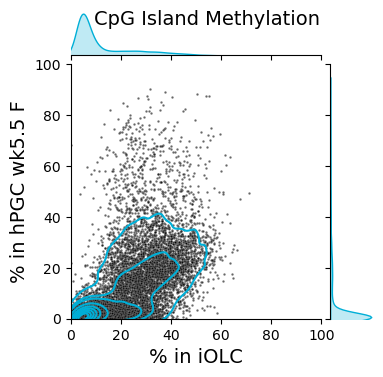

In [17]:
methyl_percent_jointplot("oogonia_new_D5", "hPGC_wk5.5_F", "% in iOLC", "% in hPGC wk5.5 F", "CpG Island Methylation",
                         CpG_aggregated, os.path.join(outdir,"CpG_islands/hPGC_wk5.5F_vs_iOLC_D5.png"),size=3.5)

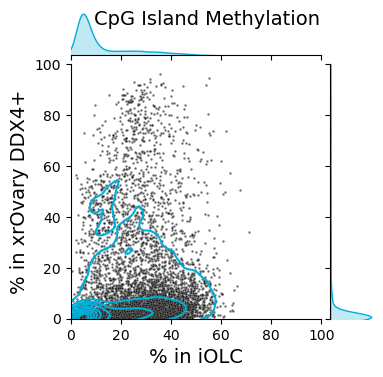

In [18]:
methyl_percent_jointplot("oogonia_new_D5", "xrOvary_day120_DDX4+", "% in iOLC", "% in xrOvary DDX4+", "CpG Island Methylation",
                         CpG_aggregated, os.path.join(outdir,"CpG_islands/iOLC_vs_xrOvary.png"),size=3.5)

# Load ICRs

In [15]:
imprints_df = aggregate_beds(base_bed="base_beds/human_imprintome_hg38_ICRs_coordinates.bed", bed_col_names = ["chr","start","end","gene"], sample_directory="data/imprints/", sample_list_df = sample_data, sample_suffix=".imprints_aggregated.bed")
imprints_aggregated = aggregate_samples(imprints_df, sample_data)
imprints_aggregated.to_csv(os.path.join(outdir,"2024-01-17_ICRs_aggregated.csv"))
imprints_aggregated

Reading: data/imprints/01_A4_1_val_1_bismark_bt2_pe.deduplicated.bismark.imprints_aggregated.bed
Reading: data/imprints/02_D3_1_val_1_bismark_bt2_pe.deduplicated.bismark.imprints_aggregated.bed
Reading: data/imprints/03_DNR3_1_val_1_bismark_bt2_pe.deduplicated.bismark.imprints_aggregated.bed
Reading: data/imprints/04_F2_1_val_1_bismark_bt2_pe.deduplicated.bismark.imprints_aggregated.bed
Reading: data/imprints/05_F3_1_val_1_bismark_bt2_pe.deduplicated.bismark.imprints_aggregated.bed
Reading: data/imprints/06_PGP1_1_val_1_bismark_bt2_pe.deduplicated.bismark.imprints_aggregated.bed
Reading: data/imprints/07_F2_D4TDZG_1_val_1_bismark_bt2_pe.deduplicated.bismark.imprints_aggregated.bed
Reading: data/imprints/08_F3_D4TGS3_1_val_1_bismark_bt2_pe.deduplicated.bismark.imprints_aggregated.bed
Reading: data/imprints/09_PGP1_D4TR8G_1_val_1_bismark_bt2_pe.deduplicated.bismark.imprints_aggregated.bed
Reading: data/imprints/10_F2_D4TDZG_1_val_1_bismark_bt2_pe.deduplicated.bismark.imprints_aggregated.

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_F,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+
0,chr1,605447,605698,ICR_1,13.409091,13.846154,15.662651,1.315789,16.058394,8.108108,...,0.000000,2.564103,84.848485,63.636364,76.470588,0.000000,0.000000,77.272727,36.842105,0.000000
1,chr1,628959,630792,ICR_2,7.197273,6.988916,1.416544,2.518080,3.252459,1.471017,...,60.215054,44.285714,36.213992,45.132743,74.489796,26.649746,17.004049,17.692308,16.517857,19.921105
2,chr1,632183,632834,ICR_3,89.849624,85.427136,65.365854,17.482517,19.298246,18.918919,...,65.979381,51.485149,61.658031,28.000000,38.888889,49.246231,29.166667,0.000000,2.564103,42.319749
3,chr1,633381,634921,ICR_4,10.985300,8.911212,2.220878,3.122670,3.673374,1.849880,...,69.285714,58.333333,29.682702,53.413655,69.072165,25.137363,19.370460,8.267717,9.016393,16.647662
5,chr1,1174554,1174597,ICR_6,51.136364,73.684211,84.782609,14.285714,12.068966,7.692308,...,0.000000,3.508772,37.560976,68.131868,57.500000,2.222222,0.000000,11.111111,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,chrX,154408925,154409317,ICR_1484,26.190476,64.864865,40.476190,6.756757,16.666667,6.976744,...,2.898551,4.687500,36.997319,12.209302,8.333333,40.476190,27.972028,0.000000,0.729927,38.356164
1484,chrX,154548296,154548666,ICR_1485,17.293233,64.516129,60.465116,14.159292,17.777778,5.405405,...,7.407407,0.000000,71.212121,50.819672,30.281690,31.277533,20.930233,0.000000,0.884956,35.789474
1485,chrX,154805812,154806063,ICR_1486,30.434783,57.407407,64.285714,15.068493,2.777778,8.571429,...,2.597403,0.000000,48.633880,26.923077,20.588235,36.153846,48.437500,0.000000,0.000000,40.909091
1486,chrX,155070793,155070856,ICR_1487,9.090909,60.416667,0.000000,4.761905,8.196721,0.000000,...,0.000000,0.000000,28.358209,0.000000,0.000000,36.416185,25.806452,0.000000,2.564103,45.859873


In [16]:
TEs_df = aggregate_beds(base_bed="base_beds/2024-01-06_RepeatMasker_UCSC_Export.bed", bed_col_names = ["chr","start","end","gene"], sample_directory="data/TEs/", sample_list_df = sample_data, sample_suffix=".TEs_aggregated.bed")

Reading: data/TEs/01_A4_1_val_1_bismark_bt2_pe.deduplicated.bismark.TEs_aggregated.bed
Reading: data/TEs/02_D3_1_val_1_bismark_bt2_pe.deduplicated.bismark.TEs_aggregated.bed
Reading: data/TEs/03_DNR3_1_val_1_bismark_bt2_pe.deduplicated.bismark.TEs_aggregated.bed
Reading: data/TEs/04_F2_1_val_1_bismark_bt2_pe.deduplicated.bismark.TEs_aggregated.bed
Reading: data/TEs/05_F3_1_val_1_bismark_bt2_pe.deduplicated.bismark.TEs_aggregated.bed
Reading: data/TEs/06_PGP1_1_val_1_bismark_bt2_pe.deduplicated.bismark.TEs_aggregated.bed
Reading: data/TEs/07_F2_D4TDZG_1_val_1_bismark_bt2_pe.deduplicated.bismark.TEs_aggregated.bed
Reading: data/TEs/08_F3_D4TGS3_1_val_1_bismark_bt2_pe.deduplicated.bismark.TEs_aggregated.bed
Reading: data/TEs/09_PGP1_D4TR8G_1_val_1_bismark_bt2_pe.deduplicated.bismark.TEs_aggregated.bed
Reading: data/TEs/10_F2_D4TDZG_1_val_1_bismark_bt2_pe.deduplicated.bismark.TEs_aggregated.bed
Reading: data/TEs/11_F3_D4TGS3_1_val_1_bismark_bt2_pe.deduplicated.bismark.TEs_aggregated.bed
Re

In [17]:
list(sample_data["sample_key"].unique())

['hPGCLC',
 'oogonia_old',
 'hiPSC_primed',
 'oogonia_new_D3',
 'oogonia_new_D5',
 'oogonia_naive',
 'hiPSC_naive',
 'hPGC_wk5.5_F',
 'hPGC_wk7_F',
 'hPGC_wk9_F',
 'hPGC_wk9_M',
 'hiPSC_primed_Yamashiro',
 'iMeLC_Yamashiro',
 'hPGCLC_Yamashiro',
 'xrOvary_day120_TFAP2C+',
 'xrOvary_day120_TFAP2C+_DDX4+',
 'xrOvary_day35',
 'xrOvary_day77',
 'xrOvary_day120_DDX4+']

In [18]:
TEs_aggregated = aggregate_samples(TEs_df, sample_data, cell_type_list = list(sample_data["sample_key"].unique()))
TEs_aggregated.to_csv(os.path.join(outdir,"2024-01-17_TEs_aggregated.csv"))
TEs_aggregated

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_F,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+
1,chr1,8388315,8388618,AluY,95.708155,100.000000,93.989071,30.857143,18.181818,21.511628,...,16.438356,4.000000,98.429319,91.150442,93.700787,34.782609,15.584416,71.264368,38.181818,18.072289
2,chr1,25165803,25166380,L1MB5,70.454545,44.000000,66.666667,12.727273,20.000000,18.421053,...,46.153846,38.461538,62.711864,60.000000,50.000000,57.894737,54.545455,40.000000,50.000000,40.740741
3,chr1,33554185,33554483,AluSc,82.812500,84.210526,89.473684,17.241379,3.571429,8.450704,...,40.000000,46.875000,95.209581,83.720930,90.566038,60.215054,73.333333,64.864865,55.952381,56.435644
4,chr1,41942894,41943205,AluY,86.764706,93.406593,97.959184,17.482517,11.000000,12.500000,...,15.000000,8.928571,92.436975,84.567901,85.555556,48.022599,34.482759,71.212121,45.959596,36.752137
5,chr1,50331336,50332274,HAL1,42.222222,77.419355,74.603175,14.473684,9.523810,4.054054,...,2.083333,0.000000,78.139535,78.504673,72.380952,7.200000,3.278689,23.456790,9.482759,3.968254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5683681,chr22_KI270739v1_random,14127,35940,ALR/Alpha,65.186916,60.975610,73.015873,9.704641,11.585366,10.714286,...,30.158730,11.627907,69.473684,75.409836,74.834437,25.581395,33.333333,54.687500,45.856354,25.675676
5683683,chr22_KI270739v1_random,38402,41851,L1PA2,45.945946,23.529412,50.000000,8.333333,5.555556,2.777778,...,10.000000,0.000000,40.000000,52.631579,40.000000,0.000000,50.000000,6.250000,26.315789,0.000000
5683686,chr22_KI270739v1_random,42530,48656,ALR/Alpha,63.636364,53.333333,80.000000,12.121212,4.545455,3.846154,...,38.888889,25.000000,42.307692,46.428571,69.444444,5.000000,16.000000,33.333333,32.352941,5.555556
5683688,chr22_KI270739v1_random,49091,50070,L1PA3,72.972973,62.500000,94.117647,31.578947,13.513514,15.384615,...,33.333333,50.000000,92.307692,94.736842,90.476190,90.909091,87.500000,90.909091,89.473684,50.000000


In [19]:
TEs_aggregated["gene"].value_counts().to_csv("all_TE_counts.csv")

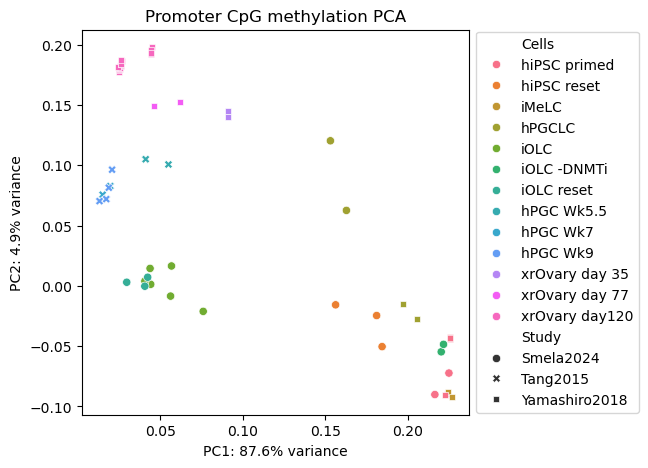

In [20]:
#Next idea: do PCA
pca_plot(proms_df, sample_data, title="Promoter CpG methylation PCA", style_key = "Study", hue_key = "Cells", hue_order = ["hiPSC primed","hiPSC reset","iMeLC", "hPGCLC", "iOLC", "iOLC -DNMTi", "iOLC reset", "hPGC Wk5.5", "hPGC Wk7", "hPGC Wk9", "xrOvary day 35", "xrOvary day 77", "xrOvary day120"])


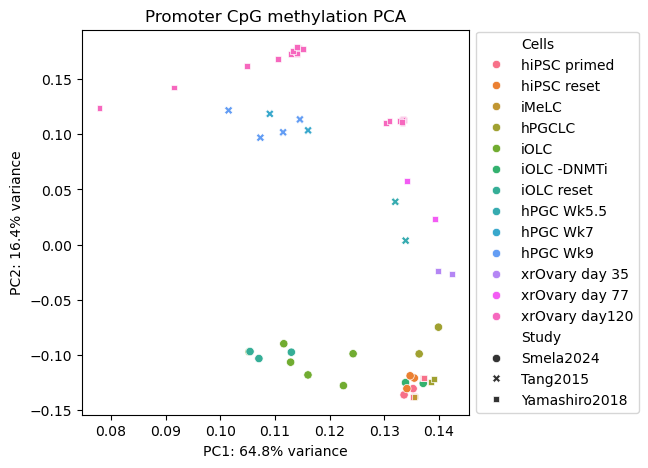

In [21]:
#Next idea: do PCA but scale it first
pca_plot_scale(proms_df, sample_data, title="Promoter CpG methylation PCA", style_key = "Study", hue_key = "Cells", hue_order = ["hiPSC primed","hiPSC reset","iMeLC", "hPGCLC", "iOLC", "iOLC -DNMTi", "iOLC reset", "hPGC Wk5.5", "hPGC Wk7", "hPGC Wk9", "xrOvary day 35", "xrOvary day 77", "xrOvary day120"])


In [22]:
#celltypes_test = ["hiPSC_primed", "hiPSC_naive", "hPGCLC", "oogonia_new_D3", "oogonia_new_D5", "oogonia_naive", "hPGC_wk5.5_F", "hPGC_wk7_F", "hPGC_wk9_F", "hPGC_wk9_M"]
#pairwise_plot(imprints_df, celltypes_test)

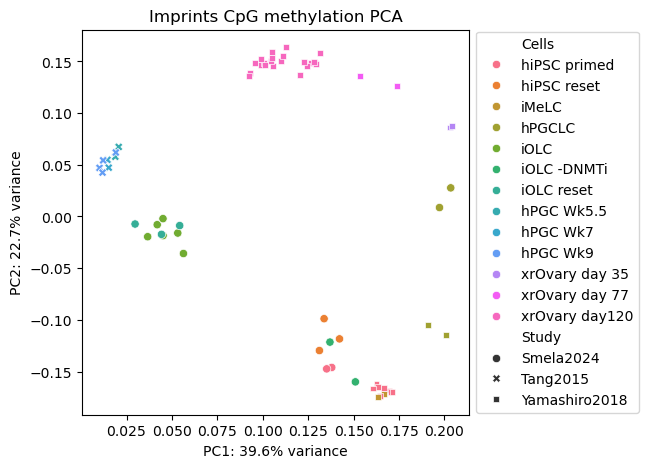

In [23]:
#Next idea: do PCA
pca_plot(imprints_df, sample_data, title="Imprints CpG methylation PCA", style_key = "Study", hue_key = "Cells", hue_order = ["hiPSC primed","hiPSC reset","iMeLC", "hPGCLC", "iOLC", "iOLC -DNMTi", "iOLC reset", "hPGC Wk5.5", "hPGC Wk7", "hPGC Wk9", "xrOvary day 35", "xrOvary day 77", "xrOvary day120"])


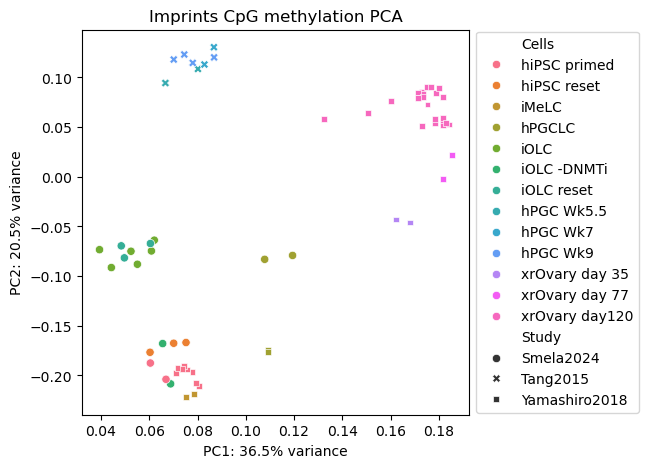

In [24]:
#Next idea: do PCA but scale it
pca_plot_scale(imprints_df, sample_data, title="Imprints CpG methylation PCA", style_key = "Study", hue_key = "Cells", hue_order = ["hiPSC primed","hiPSC reset","iMeLC", "hPGCLC", "iOLC", "iOLC -DNMTi", "iOLC reset", "hPGC Wk5.5", "hPGC Wk7", "hPGC Wk9", "xrOvary day 35", "xrOvary day 77", "xrOvary day120"])


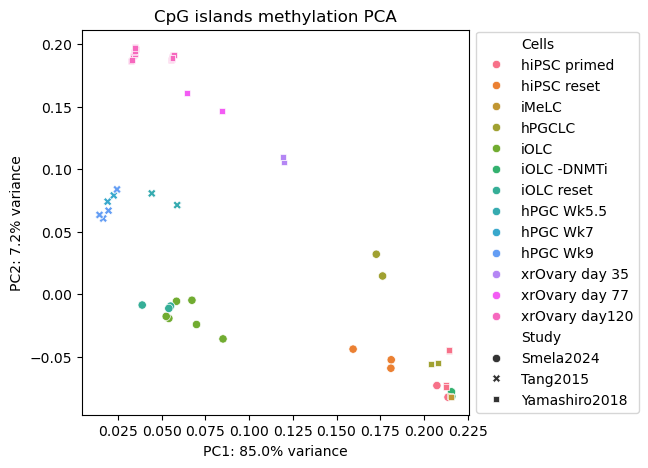

In [25]:
#Next idea: do PCA
pca_plot(islands_df, sample_data, title="CpG islands methylation PCA", style_key = "Study", hue_key = "Cells", hue_order = ["hiPSC primed","hiPSC reset","iMeLC", "hPGCLC", "iOLC", "iOLC -DNMTi", "iOLC reset", "hPGC Wk5.5", "hPGC Wk7", "hPGC Wk9", "xrOvary day 35", "xrOvary day 77", "xrOvary day120"])


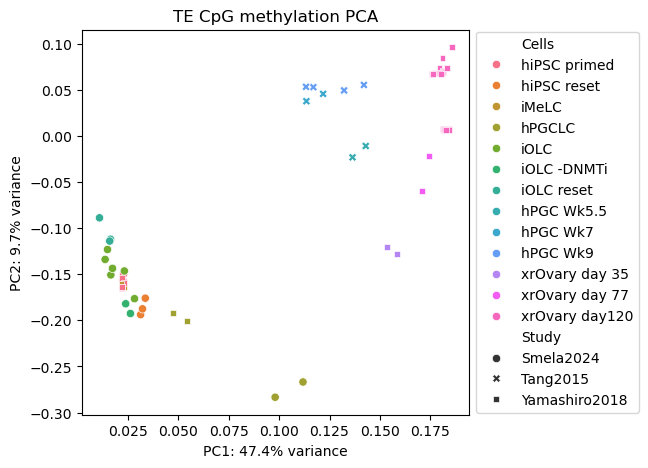

In [26]:
#Next idea: do PCA
pca_plot(TEs_df, sample_data, title="TE CpG methylation PCA", style_key = "Study", hue_key = "Cells", hue_order = ["hiPSC primed","hiPSC reset","iMeLC", "hPGCLC", "iOLC", "iOLC -DNMTi", "iOLC reset", "hPGC Wk5.5", "hPGC Wk7", "hPGC Wk9", "xrOvary day 35", "xrOvary day 77", "xrOvary day120"])


# TE analysis

In [27]:
def assign_TE_family(TE):
    if TE.startswith("L1"): return "L1"
    if TE.startswith("L2"): return "L2"
    if TE.startswith("Alu"): return "Alu"
    if TE.startswith("MIR"): return "MIR"
    if TE.startswith("SVA"): return "SVA"
    if TE.startswith("HERV1"): return "HERV1"
    if TE.startswith("HERVK"): return "HERVK"
    if TE.startswith("LTR5_Hs"): return "LTR5_Hs"
    if TE.startswith("LTR"): return "LTR_Other"
    if TE.startswith("THE1") or TE.startswith("MLT") or TE.startswith("MST"): return "ERVL-MaLR"
    return "Other"

In [28]:
TEs_aggregated["TE_family"] = TEs_aggregated["gene"].apply(assign_TE_family)
TEs_aggregated

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+,TE_family
1,chr1,8388315,8388618,AluY,95.708155,100.000000,93.989071,30.857143,18.181818,21.511628,...,4.000000,98.429319,91.150442,93.700787,34.782609,15.584416,71.264368,38.181818,18.072289,Alu
2,chr1,25165803,25166380,L1MB5,70.454545,44.000000,66.666667,12.727273,20.000000,18.421053,...,38.461538,62.711864,60.000000,50.000000,57.894737,54.545455,40.000000,50.000000,40.740741,L1
3,chr1,33554185,33554483,AluSc,82.812500,84.210526,89.473684,17.241379,3.571429,8.450704,...,46.875000,95.209581,83.720930,90.566038,60.215054,73.333333,64.864865,55.952381,56.435644,Alu
4,chr1,41942894,41943205,AluY,86.764706,93.406593,97.959184,17.482517,11.000000,12.500000,...,8.928571,92.436975,84.567901,85.555556,48.022599,34.482759,71.212121,45.959596,36.752137,Alu
5,chr1,50331336,50332274,HAL1,42.222222,77.419355,74.603175,14.473684,9.523810,4.054054,...,0.000000,78.139535,78.504673,72.380952,7.200000,3.278689,23.456790,9.482759,3.968254,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5683681,chr22_KI270739v1_random,14127,35940,ALR/Alpha,65.186916,60.975610,73.015873,9.704641,11.585366,10.714286,...,11.627907,69.473684,75.409836,74.834437,25.581395,33.333333,54.687500,45.856354,25.675676,Other
5683683,chr22_KI270739v1_random,38402,41851,L1PA2,45.945946,23.529412,50.000000,8.333333,5.555556,2.777778,...,0.000000,40.000000,52.631579,40.000000,0.000000,50.000000,6.250000,26.315789,0.000000,L1
5683686,chr22_KI270739v1_random,42530,48656,ALR/Alpha,63.636364,53.333333,80.000000,12.121212,4.545455,3.846154,...,25.000000,42.307692,46.428571,69.444444,5.000000,16.000000,33.333333,32.352941,5.555556,Other
5683688,chr22_KI270739v1_random,49091,50070,L1PA3,72.972973,62.500000,94.117647,31.578947,13.513514,15.384615,...,50.000000,92.307692,94.736842,90.476190,90.909091,87.500000,90.909091,89.473684,50.000000,L1


Plotting: Alu


/var/folders/fz/vkdsv_z91vlc2p1_50jq0b080000gn/T/ipykernel_1647/2261176993.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["hiPSC primed","hiPSC reset","hPGCLC","iOLC D3 -DNMTi","iOLC D3","iOLC D5","iOLC reset D5","hPGC wk5.5 F","hPGC wk7 F","hPGC wk9 F","hPGC wk9 M","hiPSC primed","iMeLC","hPGCLC","xrOvary day35","xrOvary day77","xrOvary day120 TFAP2C+","xrOvary day120 DDX4+ TFAP2C+","xrOvary day120 DDX4+"])


Plotting: L1


/var/folders/fz/vkdsv_z91vlc2p1_50jq0b080000gn/T/ipykernel_1647/2261176993.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["hiPSC primed","hiPSC reset","hPGCLC","iOLC D3 -DNMTi","iOLC D3","iOLC D5","iOLC reset D5","hPGC wk5.5 F","hPGC wk7 F","hPGC wk9 F","hPGC wk9 M","hiPSC primed","iMeLC","hPGCLC","xrOvary day35","xrOvary day77","xrOvary day120 TFAP2C+","xrOvary day120 DDX4+ TFAP2C+","xrOvary day120 DDX4+"])


Plotting: Other


/var/folders/fz/vkdsv_z91vlc2p1_50jq0b080000gn/T/ipykernel_1647/2261176993.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["hiPSC primed","hiPSC reset","hPGCLC","iOLC D3 -DNMTi","iOLC D3","iOLC D5","iOLC reset D5","hPGC wk5.5 F","hPGC wk7 F","hPGC wk9 F","hPGC wk9 M","hiPSC primed","iMeLC","hPGCLC","xrOvary day35","xrOvary day77","xrOvary day120 TFAP2C+","xrOvary day120 DDX4+ TFAP2C+","xrOvary day120 DDX4+"])


Plotting: L2


/var/folders/fz/vkdsv_z91vlc2p1_50jq0b080000gn/T/ipykernel_1647/2261176993.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["hiPSC primed","hiPSC reset","hPGCLC","iOLC D3 -DNMTi","iOLC D3","iOLC D5","iOLC reset D5","hPGC wk5.5 F","hPGC wk7 F","hPGC wk9 F","hPGC wk9 M","hiPSC primed","iMeLC","hPGCLC","xrOvary day35","xrOvary day77","xrOvary day120 TFAP2C+","xrOvary day120 DDX4+ TFAP2C+","xrOvary day120 DDX4+"])


Plotting: ERVL-MaLR


/var/folders/fz/vkdsv_z91vlc2p1_50jq0b080000gn/T/ipykernel_1647/2261176993.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["hiPSC primed","hiPSC reset","hPGCLC","iOLC D3 -DNMTi","iOLC D3","iOLC D5","iOLC reset D5","hPGC wk5.5 F","hPGC wk7 F","hPGC wk9 F","hPGC wk9 M","hiPSC primed","iMeLC","hPGCLC","xrOvary day35","xrOvary day77","xrOvary day120 TFAP2C+","xrOvary day120 DDX4+ TFAP2C+","xrOvary day120 DDX4+"])


Plotting: MIR


KeyboardInterrupt: 

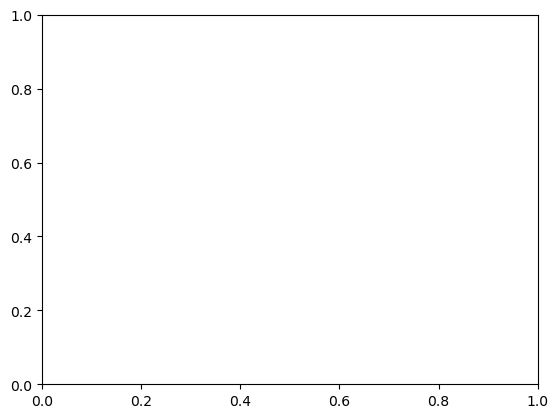

In [29]:
# Make violin plots

for TE in TEs_aggregated["TE_family"].unique():
    if os.path.isfile("2024-01-18_TE_family_plot_"+TE.replace("/","_")+".png"):
        print("Already done: " + TE)
        continue
    
    TE_data = TEs_aggregated[TEs_aggregated["TE_family"]==TE]
    print("Plotting: "+TE)
    sns.violinplot(data = TE_data.drop(["chr","start","end","gene","TE_family"], axis = 1), order = ["hiPSC_primed","hiPSC_naive","hPGCLC","oogonia_old","oogonia_new_D3","oogonia_new_D5","oogonia_naive","hPGC_wk5.5_F","hPGC_wk7_F","hPGC_wk9_F","hPGC_wk9_M","hiPSC_primed_Yamashiro","iMeLC_Yamashiro","hPGCLC_Yamashiro","xrOvary_day35","xrOvary_day77","xrOvary_day120_TFAP2C+","xrOvary_day120_TFAP2C+_DDX4+","xrOvary_day120_DDX4+"])
    plt.ylim(0,100)
    plt.xticks(rotation=90, fontsize = 14)
    ax = plt.gca()
    ax.set_xticklabels(["hiPSC primed","hiPSC reset","hPGCLC","iOLC D3 -DNMTi","iOLC D3","iOLC D5","iOLC reset D5","hPGC wk5.5 F","hPGC wk7 F","hPGC wk9 F","hPGC wk9 M","hiPSC primed","iMeLC","hPGCLC","xrOvary day35","xrOvary day77","xrOvary day120 TFAP2C+","xrOvary day120 DDX4+ TFAP2C+","xrOvary day120 DDX4+"])
    #plt.ylabel("CpG methylation %")
    #plt.xlabel("Sample type")
    plt.title(TE, fontsize = 18)
    plt.savefig(outdir+"/2024-01-18_TE_family_plot_"+TE.replace("/","_")+".png", dpi=256, bbox_inches = "tight")
    plt.savefig(outdir+"/2024-01-18_TE_family_plot_"+TE.replace("/","_")+".svg", bbox_inches = "tight")
    plt.close()


In [30]:
escapee_cutoff = 80
iOLC_TEs_avg = (TEs_aggregated["oogonia_naive"] + TEs_aggregated["oogonia_new_D3"] + TEs_aggregated["oogonia_new_D5"])/3
oogonia_TEs_df_escapees_80 = TEs_aggregated[iOLC_TEs_avg > escapee_cutoff]
oogonia_TEs_df_escapees_80

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+,TE_family
3633,chr1,1706372,1706557,AluJo,89.473684,100.000000,100.000000,78.571429,85.714286,83.333333,...,0.000000,81.818182,100.000000,81.250000,38.888889,0.000000,25.000000,36.842105,0.000000,Alu
9746,chr1,5815875,5815954,MADE1,71.428571,100.000000,94.736842,95.000000,89.473684,71.428571,...,0.000000,92.000000,71.428571,90.909091,13.333333,11.111111,20.000000,0.000000,10.526316,Other
14889,chr1,8455078,8455132,(CCAGGAG)n,80.000000,90.909091,83.333333,92.307692,75.000000,87.500000,...,0.000000,86.666667,93.750000,94.736842,13.636364,0.000000,27.272727,0.000000,0.000000,Other
15108,chr1,8555122,8555383,MER58B,100.000000,87.500000,100.000000,91.666667,75.000000,81.818182,...,28.571429,92.307692,95.833333,100.000000,84.615385,91.666667,90.476190,95.454545,81.818182,Other
15794,chr1,8866676,8866804,FLAM_A,90.476190,100.000000,100.000000,83.333333,80.000000,88.888889,...,0.000000,98.148148,92.000000,100.000000,48.484848,41.666667,72.727273,65.384615,41.666667,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200448,chr21,25862075,25862111,L1PA6,14.285714,100.000000,80.000000,85.714286,93.333333,63.636364,...,0.000000,84.444444,77.272727,23.809524,0.000000,0.000000,0.000000,0.000000,0.000000,L1
5207269,chr21,29801234,29801314,MADE1,68.965517,100.000000,100.000000,95.000000,84.210526,81.081081,...,30.769231,85.714286,85.714286,86.956522,4.000000,0.000000,27.777778,6.666667,6.060606,Other
5249556,chr22,20724137,20724319,AluSp,100.000000,100.000000,93.333333,90.909091,75.000000,75.000000,...,11.111111,84.210526,90.909091,80.000000,50.000000,50.000000,85.714286,46.153846,44.444444,Alu
5256314,chr22,24136725,24136767,(CA)n,81.818182,100.000000,87.500000,100.000000,75.000000,66.666667,...,0.000000,83.333333,71.428571,56.521739,38.888889,0.000000,40.000000,50.000000,0.000000,Other


In [31]:
escapee_cutoff = 80
iOLC_TEs_avg = (TEs_aggregated["oogonia_naive"] + TEs_aggregated["oogonia_new_D3"] + TEs_aggregated["oogonia_new_D5"])/3
oogonia_TEs_df_escapees_80 = TEs_aggregated[iOLC_TEs_avg > escapee_cutoff]
oogonia_TEs_df_escapees_80

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+,TE_family
3633,chr1,1706372,1706557,AluJo,89.473684,100.000000,100.000000,78.571429,85.714286,83.333333,...,0.000000,81.818182,100.000000,81.250000,38.888889,0.000000,25.000000,36.842105,0.000000,Alu
9746,chr1,5815875,5815954,MADE1,71.428571,100.000000,94.736842,95.000000,89.473684,71.428571,...,0.000000,92.000000,71.428571,90.909091,13.333333,11.111111,20.000000,0.000000,10.526316,Other
14889,chr1,8455078,8455132,(CCAGGAG)n,80.000000,90.909091,83.333333,92.307692,75.000000,87.500000,...,0.000000,86.666667,93.750000,94.736842,13.636364,0.000000,27.272727,0.000000,0.000000,Other
15108,chr1,8555122,8555383,MER58B,100.000000,87.500000,100.000000,91.666667,75.000000,81.818182,...,28.571429,92.307692,95.833333,100.000000,84.615385,91.666667,90.476190,95.454545,81.818182,Other
15794,chr1,8866676,8866804,FLAM_A,90.476190,100.000000,100.000000,83.333333,80.000000,88.888889,...,0.000000,98.148148,92.000000,100.000000,48.484848,41.666667,72.727273,65.384615,41.666667,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5200448,chr21,25862075,25862111,L1PA6,14.285714,100.000000,80.000000,85.714286,93.333333,63.636364,...,0.000000,84.444444,77.272727,23.809524,0.000000,0.000000,0.000000,0.000000,0.000000,L1
5207269,chr21,29801234,29801314,MADE1,68.965517,100.000000,100.000000,95.000000,84.210526,81.081081,...,30.769231,85.714286,85.714286,86.956522,4.000000,0.000000,27.777778,6.666667,6.060606,Other
5249556,chr22,20724137,20724319,AluSp,100.000000,100.000000,93.333333,90.909091,75.000000,75.000000,...,11.111111,84.210526,90.909091,80.000000,50.000000,50.000000,85.714286,46.153846,44.444444,Alu
5256314,chr22,24136725,24136767,(CA)n,81.818182,100.000000,87.500000,100.000000,75.000000,66.666667,...,0.000000,83.333333,71.428571,56.521739,38.888889,0.000000,40.000000,50.000000,0.000000,Other


In [32]:
escapee_cutoff = 60
hPGC_cols = TEs_aggregated.columns.str.contains("hPGC_")
hPGC_TEs_avg = TEs_aggregated.loc[:,hPGC_cols].mean(axis = 1)
hPGC_TEs_df_escapees_60 = TEs_aggregated[hPGC_TEs_avg > escapee_cutoff]
hPGC_TEs_df_escapees_60

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+,TE_family
38,chr1,40893495,40895081,THE1D-int,80.769231,100.000000,94.444444,15.151515,29.411765,15.789474,...,70.588235,78.823529,55.555556,59.375000,90.384615,83.333333,72.222222,57.575758,87.234043,ERVL-MaLR
43,chr1,49282507,49288376,L1PA2,83.333333,83.842011,81.666667,18.882979,18.013468,8.163265,...,62.500000,83.597122,90.250329,84.284051,74.412855,69.086022,74.267101,74.163783,67.728532,L1
60,chr1,94371759,94372318,LTR12,92.957746,87.179487,76.923077,34.328358,33.766234,19.512195,...,81.250000,86.772487,86.138614,93.617021,86.046512,81.967213,86.075949,80.672269,85.840708,LTR_Other
94,chr1,193986287,193986874,L1PA13,70.000000,80.000000,88.235294,0.000000,36.363636,0.000000,...,80.000000,86.956522,90.909091,92.857143,81.250000,50.000000,40.000000,93.333333,77.777778,L1
129,chr1,4325192,4325435,AluJo,91.666667,83.333333,100.000000,10.000000,20.000000,20.000000,...,85.714286,100.000000,96.000000,100.000000,90.909091,76.923077,100.000000,90.476190,82.608696,Alu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5683421,chr22_KI270735v1_random,42193,42287,AluJb,63.157895,62.500000,78.260870,8.108108,0.000000,3.225806,...,58.333333,66.666667,72.222222,69.565217,75.000000,30.000000,57.142857,47.619048,70.000000,Alu
5683428,chr22_KI270736v1_random,2802,3258,MLT1O,60.869565,86.363636,90.000000,13.636364,13.043478,8.333333,...,100.000000,78.571429,95.238095,96.296296,54.285714,68.421053,50.000000,90.476190,54.545455,ERVL-MaLR
5683452,chr22_KI270736v1_random,14494,14736,MIR,100.000000,50.000000,33.333333,23.076923,0.000000,0.000000,...,100.000000,58.333333,71.428571,75.000000,62.500000,42.857143,50.000000,80.000000,77.272727,MIR
5683609,chr22_KI270737v1_random,94173,94347,L1MEc,86.666667,83.333333,100.000000,17.647059,10.526316,10.000000,...,100.000000,73.809524,50.000000,46.666667,75.000000,100.000000,20.000000,57.142857,94.117647,L1


In [33]:
escapee_cutoff = 80
hPGC_cols = TEs_aggregated.columns.str.contains("hPGC_")
hPGC_TEs_avg = TEs_aggregated.loc[:,hPGC_cols].mean(axis = 1)
hPGC_TEs_df_escapees_80 = TEs_aggregated[hPGC_TEs_avg > escapee_cutoff]
hPGC_TEs_df_escapees_80

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+,TE_family
522,chr1,111411091,111411238,L1PA14,100.000000,100.000000,75.000000,26.666667,20.000000,16.666667,...,75.000000,95.000000,100.000000,100.000000,100.000000,100.000000,100.000000,90.000000,100.000000,L1
1036,chr1,74897,76697,L1PA2,91.176471,92.857143,83.720930,22.916667,18.181818,20.689655,...,60.000000,79.591837,72.727273,78.947368,78.947368,80.000000,78.947368,75.000000,67.857143,L1
2166,chr1,754346,755409,MER11C,91.194969,90.909091,89.655172,30.434783,21.538462,15.277778,...,100.000000,77.777778,100.000000,100.000000,100.000000,71.428571,100.000000,75.000000,100.000000,Other
2242,chr1,785993,786249,LTR104_Mam,84.615385,94.117647,100.000000,37.500000,14.285714,55.555556,...,75.000000,88.000000,100.000000,90.909091,91.666667,100.000000,81.818182,94.736842,100.000000,LTR_Other
2673,chr1,1113211,1113335,MER50,90.909091,100.000000,88.888889,35.483871,42.105263,15.384615,...,84.615385,95.522388,97.826087,100.000000,86.868687,93.750000,90.909091,95.454545,87.272727,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676732,chr4_GL000008v2_random,68633,68928,AluJb,100.000000,100.000000,96.000000,30.434783,22.222222,0.000000,...,100.000000,80.000000,69.230769,88.235294,71.428571,20.000000,100.000000,94.117647,76.923077,Alu
5681317,chr16_KI270728v1_random,1459102,1459226,AluSz6,37.500000,53.846154,70.833333,8.000000,11.111111,0.000000,...,66.666667,92.857143,100.000000,100.000000,28.571429,28.571429,71.428571,83.333333,44.444444,Alu
5681528,chr16_KI270728v1_random,1554486,1554754,AluJr,72.340426,91.666667,61.538462,11.764706,33.333333,12.903226,...,58.139535,90.666667,88.888889,74.509804,48.214286,45.000000,58.064516,42.372881,43.750000,Alu
5682721,chr22_KI270732v1_random,21351,21622,MLT1D,72.500000,70.270270,90.000000,11.764706,11.320755,5.405405,...,90.000000,100.000000,85.714286,95.652174,90.476190,100.000000,92.307692,75.000000,88.000000,ERVL-MaLR


In [34]:
print(hPGC_TEs_df_escapees_80[["oogonia_naive","oogonia_new_D3","oogonia_new_D5"]].mean().mean())

26.8547486842464


TE_family
L1           3331
Alu          2410
Other        1853
ERVL-MaLR    1740
LTR_Other     417
L2            411
MIR           410
HERVK          19
SVA            12
HERV1          12
Name: count, dtype: int64


([<matplotlib.patches.Wedge at 0x1c4430b60>,
 [Text(0.607383270540812, 0.9171071707642172, ''),
  Text(-0.9872818746974271, 0.48505102813408596, ''),
  Text(-0.762418088484787, -0.7929178131125595, ''),
  Text(0.3225341373463089, -1.0516519054545912, ''),
  Text(0.8856900751677541, -0.652344303837581, ''),
  Text(1.0174934346009474, -0.4179797968131568, ''),
  Text(1.0881694363511585, -0.16089523855976065, ''),
  Text(1.099783750437745, -0.02181060001669657, ''),
  Text(1.0999375663781585, -0.011719644623212287, ''),
  Text(1.0999930630268806, -0.003906570457751528, '')])

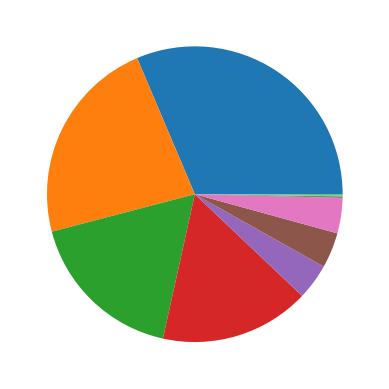

In [35]:
value_counts = hPGC_TEs_df_escapees_80["TE_family"].value_counts()
value_counts = hPGC_TEs_df_escapees_80['TE_family'].value_counts()

# Identify values with count less than 10
values_to_replace = value_counts[value_counts < 6].index

# Replace those values with 'other'
df2 = hPGC_TEs_df_escapees_80['TE_family'].replace(values_to_replace, 'other')

print(df2.value_counts())
plt.pie(df2.value_counts())

In [36]:
df2.value_counts().to_csv("TE_freq.csv")

In [37]:
from matplotlib_venn import venn2, venn3

In [45]:
escapee_cutoff = 60
xrOvary_cols = TEs_aggregated.columns.str.contains("xrOvary_day120")
xrOvary_TEs_avg = TEs_aggregated.loc[:,xrOvary_cols].mean(axis = 1)
xrOvary_TEs_df_escapees_60 = TEs_aggregated[xrOvary_TEs_avg > escapee_cutoff]
xrOvary_TEs_df_escapees_60

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+,TE_family
3,chr1,33554185,33554483,AluSc,82.812500,84.210526,89.473684,17.241379,3.571429,8.450704,...,46.875000,95.209581,83.720930,90.566038,60.215054,73.333333,64.864865,55.952381,56.435644,Alu
9,chr1,100662981,100669120,L1PA4,57.601351,79.202279,82.066277,18.729642,14.932127,9.740260,...,52.153110,86.305732,87.265136,80.710660,62.627986,58.695652,66.076696,58.812616,60.902256,L1
38,chr1,40893495,40895081,THE1D-int,80.769231,100.000000,94.444444,15.151515,29.411765,15.789474,...,70.588235,78.823529,55.555556,59.375000,90.384615,83.333333,72.222222,57.575758,87.234043,ERVL-MaLR
43,chr1,49282507,49288376,L1PA2,83.333333,83.842011,81.666667,18.882979,18.013468,8.163265,...,62.500000,83.597122,90.250329,84.284051,74.412855,69.086022,74.267101,74.163783,67.728532,L1
44,chr1,51380074,51380249,AluSq,95.121951,93.478261,92.307692,35.483871,14.583333,22.222222,...,30.434783,97.435897,96.385542,92.307692,78.260870,61.363636,75.000000,71.929825,65.853659,Alu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5683667,chr22_KI270738v1_random,72859,72982,(ATCATCGAATGGA)n,84.466019,87.719298,84.848485,5.063291,23.076923,9.821429,...,33.333333,88.000000,75.471698,80.851064,74.698795,54.237288,66.000000,58.227848,61.176471,Other
5683668,chr22_KI270738v1_random,73278,73349,(TCGAATGGAA)n,92.156863,83.333333,98.461538,15.294118,14.893617,0.000000,...,47.619048,86.013986,81.034483,84.883721,69.230769,68.000000,81.250000,72.222222,67.567568,Other
5683669,chr22_KI270738v1_random,74078,74150,(ATCGAATGGA)n,83.333333,87.096774,88.235294,17.829457,15.662651,5.084746,...,33.333333,81.632653,87.096774,75.000000,72.549020,82.352941,83.673469,59.722222,70.000000,Other
5683670,chr22_KI270738v1_random,75911,75977,(GAATGGAATC)n,85.321101,83.928571,93.243243,9.638554,14.102564,12.500000,...,21.052632,85.106383,78.125000,82.857143,65.116279,81.818182,72.413793,71.428571,56.666667,Other


In [46]:
escapee_cutoff = 60
xrOvary_DDX4_cols = TEs_aggregated.columns.str.contains("DDX4+")
xrOvary_DDX4_TEs_avg = TEs_aggregated.loc[:,xrOvary_DDX4_cols].mean(axis = 1)
xrOvary_DDX4_TEs_df_escapees_60 = TEs_aggregated[xrOvary_DDX4_TEs_avg > escapee_cutoff]
xrOvary_DDX4_TEs_df_escapees_60

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+,TE_family
3,chr1,33554185,33554483,AluSc,82.812500,84.210526,89.473684,17.241379,3.571429,8.450704,...,46.875000,95.209581,83.720930,90.566038,60.215054,73.333333,64.864865,55.952381,56.435644,Alu
38,chr1,40893495,40895081,THE1D-int,80.769231,100.000000,94.444444,15.151515,29.411765,15.789474,...,70.588235,78.823529,55.555556,59.375000,90.384615,83.333333,72.222222,57.575758,87.234043,ERVL-MaLR
43,chr1,49282507,49288376,L1PA2,83.333333,83.842011,81.666667,18.882979,18.013468,8.163265,...,62.500000,83.597122,90.250329,84.284051,74.412855,69.086022,74.267101,74.163783,67.728532,L1
44,chr1,51380074,51380249,AluSq,95.121951,93.478261,92.307692,35.483871,14.583333,22.222222,...,30.434783,97.435897,96.385542,92.307692,78.260870,61.363636,75.000000,71.929825,65.853659,Alu
53,chr1,74448281,74449467,L1PA2,79.687500,85.106383,93.939394,25.000000,13.513514,23.076923,...,60.000000,93.333333,75.000000,85.714286,90.000000,60.000000,100.000000,81.818182,81.818182,L1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5683665,chr22_KI270738v1_random,66242,66295,(AATGGAATCA)n,77.500000,85.000000,82.857143,15.625000,10.000000,20.689655,...,60.000000,94.594595,100.000000,93.750000,78.378378,80.000000,78.571429,43.750000,53.846154,Other
5683668,chr22_KI270738v1_random,73278,73349,(TCGAATGGAA)n,92.156863,83.333333,98.461538,15.294118,14.893617,0.000000,...,47.619048,86.013986,81.034483,84.883721,69.230769,68.000000,81.250000,72.222222,67.567568,Other
5683669,chr22_KI270738v1_random,74078,74150,(ATCGAATGGA)n,83.333333,87.096774,88.235294,17.829457,15.662651,5.084746,...,33.333333,81.632653,87.096774,75.000000,72.549020,82.352941,83.673469,59.722222,70.000000,Other
5683670,chr22_KI270738v1_random,75911,75977,(GAATGGAATC)n,85.321101,83.928571,93.243243,9.638554,14.102564,12.500000,...,21.052632,85.106383,78.125000,82.857143,65.116279,81.818182,72.413793,71.428571,56.666667,Other


In [48]:
escapee_cutoff = 80
xrOvary_DDX4_cols = TEs_aggregated.columns.str.contains("_DDX4+")
xrOvary_DDX4_TEs_avg = TEs_aggregated.loc[:,xrOvary_DDX4_cols].mean(axis = 1)
xrOvary_DDX4_TEs_df_escapees_80 = TEs_aggregated[xrOvary_DDX4_TEs_avg > escapee_cutoff]
xrOvary_DDX4_TEs_df_escapees_80

,chr,start,end,gene,hPGCLC,oogonia_old,hiPSC_primed,oogonia_new_D3,oogonia_new_D5,oogonia_naive,...,hPGC_wk9_M,hiPSC_primed_Yamashiro,iMeLC_Yamashiro,hPGCLC_Yamashiro,xrOvary_day120_TFAP2C+,xrOvary_day120_TFAP2C+_DDX4+,xrOvary_day35,xrOvary_day77,xrOvary_day120_DDX4+,TE_family
38,chr1,40893495,40895081,THE1D-int,80.769231,100.000000,94.444444,15.151515,29.411765,15.789474,...,70.588235,78.823529,55.555556,59.375000,90.384615,83.333333,72.222222,57.575758,87.234043,ERVL-MaLR
60,chr1,94371759,94372318,LTR12,92.957746,87.179487,76.923077,34.328358,33.766234,19.512195,...,81.250000,86.772487,86.138614,93.617021,86.046512,81.967213,86.075949,80.672269,85.840708,LTR_Other
64,chr1,104857344,104857698,THE1B,88.235294,100.000000,100.000000,44.444444,40.000000,15.384615,...,30.000000,100.000000,91.666667,89.285714,72.972973,85.714286,85.000000,100.000000,81.081081,ERVL-MaLR
132,chr1,5373460,5374205,LTR8B,85.057471,90.566038,94.029851,14.102564,15.789474,7.692308,...,65.277778,95.470383,94.193548,94.767442,89.411765,87.272727,90.384615,84.722222,90.532544,LTR_Other
145,chr1,9174707,9175275,MLT1E1A,94.666667,95.535714,95.808383,44.230769,48.366013,35.849057,...,67.647059,95.945946,94.915254,96.764706,80.258900,82.692308,83.870968,85.161290,78.378378,ERVL-MaLR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5682741,chr22_KI270732v1_random,33215,33299,AluSq,93.087558,90.714286,95.180723,17.757009,12.048193,11.255411,...,0.000000,94.017094,89.361702,87.719298,76.000000,80.000000,91.891892,88.059701,81.818182,Alu
5683067,chr22_KI270733v1_random,173057,173098,GA-rich,63.636364,40.000000,45.238095,13.286713,15.151515,13.761468,...,0.000000,67.391304,52.380952,61.538462,89.130435,87.500000,83.783784,79.591837,97.297297,Other
5683371,chr22_KI270735v1_random,15623,15738,AluJo,77.777778,78.571429,100.000000,13.636364,8.695652,0.000000,...,0.000000,79.166667,77.777778,83.333333,94.444444,100.000000,71.428571,47.368421,88.888889,Alu
5683609,chr22_KI270737v1_random,94173,94347,L1MEc,86.666667,83.333333,100.000000,17.647059,10.526316,10.000000,...,100.000000,73.809524,50.000000,46.666667,75.000000,100.000000,20.000000,57.142857,94.117647,L1


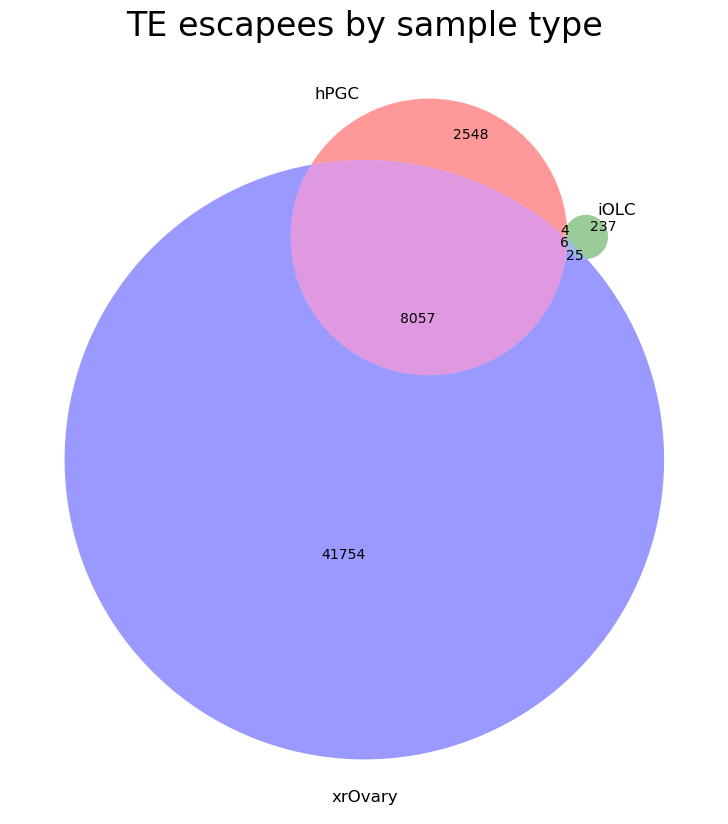

In [53]:
plt.rcParams['figure.figsize'] = [10, 10]
venn3([set(hPGC_TEs_df_escapees_80.index), set(oogonia_TEs_df_escapees_80.index), set(xrOvary_DDX4_TEs_df_escapees_80.index)],
     set_labels = ["hPGC", "iOLC", "xrOvary"])
plt.title("TE escapees by sample type", fontsize=24)
plt.savefig("2024-01-28_escapee_Venn.svg",bbox_inches="tight")
plt.savefig("2024-01-28_escapee_Venn.png",dpi=256,bbox_inches="tight")

In [ ]:
TEs_aggregated